<h3><div style="text-align: right"> Tim Wilcox </div>
<div style="text-align: right"> ISYE 6740x</div>
<div style="text-align: right"> Homework # 3 </div></h3>

<b><h2>Implementing EM algorithm for MNIST dataset. (50 points)</h2><br>

*Implement the EM algorithm for fitting a Gaussian mixture  model for the MNIST dataset. We reduce the dataset to be only two cases of digits "2" and "6" only. Thus, you will fit GMM with C = 2. Use the data file <b>data.dat</b> or <b>data.mat</b> on Canvas. True label of the data are also provided in <b>label.mat</b> and <b>label.dat</b>.
The matrix <b>images</b> is of size 784-by-1990, i.e., there are totally 1990 images, and each column of the matrix corresponds to one image of size 28-by-28 pixels (the image is vectorized; the original image can be recovered, e.g., using MATLAB code, <b>reshape(images(:,1),28,28)</b>.*

 (a)  *Select from data one raw image of "2" and "6" and visualize them, respectively:*</b>

In [1]:
# read data and do preprocessing (unscrew the column order storage artifact!)
import pandas as pd
import math
import matplotlib.pyplot as plt

data = pd.read_csv('data.dat', sep='\s+', header=None).values
(P, N) = data.shape
p = int(math.sqrt(P))
data = data.T.reshape((N, p, p), order='F').reshape((N,P)).T


(-0.5, 27.5, 27.5, -0.5)

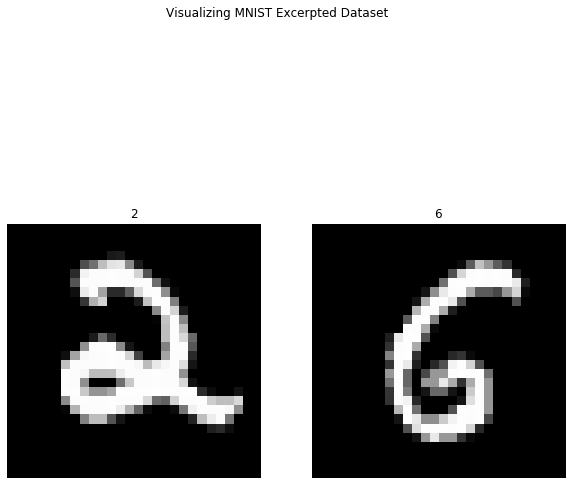

In [2]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle('Visualizing MNIST Excerpted Dataset')
ax1.imshow(data[:,666].reshape((p,p)), cmap = 'gray')
ax1.set_title('2')
ax1.axis('off')
ax2.imshow(data[:,1492].reshape((p,p)), cmap = 'gray')
ax2.set_title('6')
ax2.axis('off')


  <b>(b)    *Use  random  Gaussian  vector  with  zero  mean  as  initial  means,  and  identity  matrix  as  initialcovariance matrix for the clusters.  Please plot the log-likelihood function versus the number ofiterations to show your algorithm is converging.*</b>

In [3]:
def EM_for_GMM(X, K=2, r=30, tol=1e-15, max_iter=25, scaled=False):
    import numpy as np
    import matplotlib.pyplot as plt
    import math
    from copy import deepcopy
    from sklearn.preprocessing import scale, Normalizer
    from scipy.stats import multivariate_normal as mvn
    
    transformer = Normalizer()
    
    if scaled == False:
        X = scale(X)
    (P,N) = X.shape
    N_k = np.zeros((K))
    mu_k = np.zeros((K,P))
    splits = np.split(X, K, axis=1)
    for i in range(K):
        mu_k[i] = np.mean(splits[i])
    Sigma_k = np.zeros((K,P,P))
    for i in range(K):
        Sigma_k[i] = np.cov(splits[i])
    pi = np.zeros((K))
    for i in range(K):
        pi[i] = 0.5
    U = np.zeros((K,P,P))
    V = np.zeros((K,P))
    U_r = np.zeros((K,P,r))
    V_r = np.zeros((K,r))
    Sigma_r = np.zeros((K,P,P))
    tau = np.zeros((K,N))
    tausaver = np.zeros((0,K,N))
    Density = np.zeros((K,N))
    LLsave = np.zeros((1,1))
    musave = np.zeros((0,K,P))
    
    error = 10000
    iter_ct = 0
    
    while iter_ct < max_iter and error > tol:
        iter_ct += 1 
        print('EM +GMM iteration number {}'.format(iter_ct))
        tau_old = deepcopy(tau)
        mu_old = deepcopy(mu_k)
        Sigma_old = deepcopy(Sigma_k)
        

        for i in range(K):
            V[i], U[i] = np.linalg.eigh(Sigma_k[i])
            idx = V[i].argsort()
            V[i] = np.array(V[i][idx])
            U[i] = np.array(U[i][idx])
            U_r[i] = U[i][:,P-r:P]
            V_r[i] = V[i,P-r:P]
            Sigma_k[i] = U_r[i] @ np.diag(V_r[i]) @ U_r[i].T
            Density[i] = mvn.pdf(X.T, mean=mu_k[i], cov = Sigma_k[i], allow_singular=True)
            
            
        tau = (pi.reshape((K,1)) * Density) / np.sum(pi.reshape((K,1)) * Density, axis = 0)
        N_k = np.sum(tau, axis = 1)
        mu_k = np.zeros((K,P)) #reset mu_k
        
        
        for i in range(K):
            pi[i] = tau[i,:].sum()/N
            for j in range(N):
                mu_k[i] += 1/N_k[i] * Density[i,j] * X[:,j]
            

        for i in range(K):
            for j in range(N):
                Sigma_k[i] += 1/N_k[i] * Density[i,j] * (X - mu_k[i].reshape((P,1))) @ (X - mu_k[i].reshape((P,1))).T
        LL = np.array(np.sum(np.log(np.sum(pi.reshape((K,1)) * Density, axis=0)))).reshape((1,1))
        error1 = np.linalg.norm(tau - tau_old)**2
        error2 = np.linalg.norm(mu_k - mu_old)**2 
        print(error1, error2)
        error = np.max([error1, error2])
        tausaver = np.append(tausaver, tau.reshape((1,K,N)), axis = 0)
        LLsave = np.append(LLsave, LL, axis=0)
        musave = np.append(musave, mu_k.reshape((1,K,P)), axis = 0)
    print('done')
    return mu_k, musave, tau, pi, N_k, LLsave, iter_ct
mu_k, mus, tau_k, pi, N_k, LgLks, iterations = EM_for_GMM(data, r=75, max_iter=12)

EM +GMM iteration number 1
1981.5737852329275 3.609057270863628e-33
EM +GMM iteration number 2
0.00979141684721586 1.9608017947686345e-140
EM +GMM iteration number 3
7.142705548716548e-07 1.4296501214427322e-144
EM +GMM iteration number 4
5.204305340052621e-11 1.0416659754720323e-148
EM +GMM iteration number 5
3.791893596038461e-15 7.600983724033278e-153
EM +GMM iteration number 6
2.7604225972180253e-19 6.206518722017963e-157
done


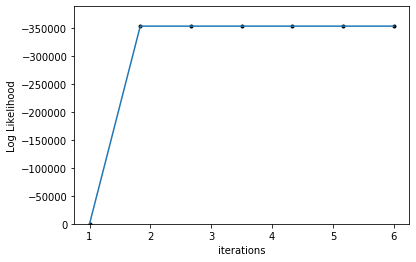

In [4]:
import numpy as np 
from scipy.interpolate import make_interp_spline, BSpline
from matplotlib import pyplot as plt
# iterations = 50
xnew = np.linspace(1, iterations, iterations+1)



plt.plot(xnew[0:], LgLks[0:], 'k.')
plt.plot(xnew[0:], LgLks[0:])
plt.ylim((1.1*max(LgLks), 1.1*min(LgLks)))
plt.ylabel('Log Likelihood')
plt.xlabel('iterations')

plt.show()

As you can see from the above graph the log-likelihood function is converging. The steps to update $\mu_k$ and $\Sigma_k$ definitely take the longest to complete. The size of $r$ has a large impact on how accurate the runs are, as well as how quickly it converges -- a large $r$ takes more time to complete an iteration. I found that I had to reset $\mu_k$ on each iteration (this took me forever to realize it), but once I did a lot of my divide by zero errors and blank mean image problems disappeard. I believe this version of the algorithm to be quite robust. I  relied heavily on the low-rank approximation of $\Sigma_k$, but with a large enough $r$ it doesn't seem to cause any issues. 

<b>  (c)    *Report the finally fitting GMM model when EM terminates: the weights for each component, the mean vectors (please reformat the vectors into 28-by-28 images and show these images in your submission). Ideally, you should be able to see these means corresponds to "average" images. No need to report the covariance matrices.*</b>

In [5]:
K = 2
for i in range(K):
    print('A glimpse of the weights for cluster {}:\n\n {} \n'.format(i, tau_k[i]))

A glimpse of the weights for cluster 0:

 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.28078550e-09
 7.03981627e-22 1.48166397e-17] 

A glimpse of the weights for cluster 1:

 [3.43892254e-18 2.80363635e-35 7.73988233e-18 ... 9.99999999e-01
 1.00000000e+00 1.00000000e+00] 



The weights are available in the object **tau_k** which has dimensions $\rm I\!R^{2 x 1990}$.

Below, we plot the mean vectors (these are also available in the **mu_k** object which has dimensions $\rm I\!R^{2 x 784}$. Additionally, the $\mu_k$ values from all iterations are saved in the <b>mus</b> object.

(-0.5, 27.5, 27.5, -0.5)

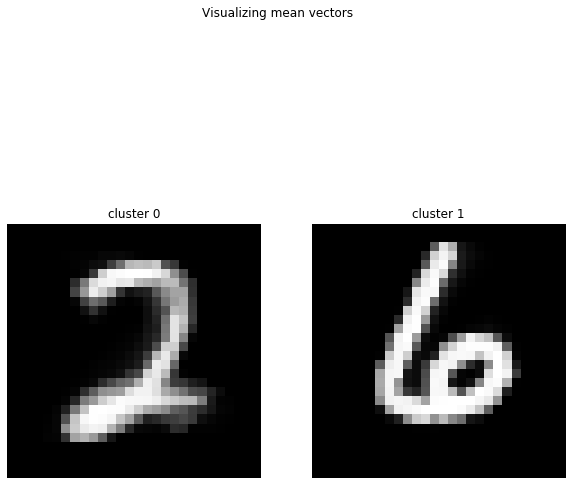

In [6]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig.suptitle('Visualizing mean vectors')
ax1.imshow(mu_k[0].reshape((p,p)), cmap = 'gray')
ax1.set_title('cluster 0')
ax1.axis('off')
ax2.imshow(mu_k[1].reshape((p,p)), cmap = 'gray')
ax2.set_title('cluster 1')
ax2.axis('off')

<b>(d)  (Optional).  *Use the $\tau_c$ to infer the labels of the images, and compare with the true labels.  Report the miss classification rate for digits “2” and “6” respectively.  Perform K-means clustering with K= 2.  Find out the miss classification rate for digits “2” and “6” respectively, and compare with GMM. Which one achieves the better performance?*</b>

In [10]:
truelabels = pd.read_csv('label.dat', sep = '\s+', header=None).values
truelabels = (truelabels == 2).astype(int)

EMGMMlabels = (tau_k[0]>0.5).astype(int)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = K).fit(data.T)
Klabels = kmeans.labels_

Kscore = np.sum(Klabels == truelabels)/N
EMGMMscore = np.sum(EMGMMlabels == truelabels)/N

print('The EM +GMM method scores {}% accuracy.'.format(round(EMGMMscore*100)))
print('The KMeans method scores {}% accuracy.'.format(round(Kscore*100)))

The EM +GMM method scores 96.0% accuracy.
The KMeans method scores 94.0% accuracy.


The EM +GMM algorithm performs better on the data but takes several iterations to converge (depends on r). On my rig, with $r \approx 100$ it took around 20 minutes to complete a run. The classification is better with EM +GMM but can't match the speed of K-Means. K-Means takes just a few seconds to complete. Depending on the above, you might have to play with the $\tau_k$ and **Klabels** objects so that they display the correct orientation. However, with $r\approx 100$ I was getting EM +GMM scores of about 96%. KMeans does around 94% every time. 